In [27]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [28]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [29]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [30]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
from sqlalchemy import create_engine,inspect, func, Table, Column, Integer, String, Date, Float

In [31]:
# reflect an existing database into a new model
inspector = inspect(engine)

meas_columns = inspector.get_columns('measurement')
for c in meas_columns:
    print(c['name'], c["type"])

    stat_columns = inspector.get_columns('station')
for c in stat_columns:
    print(c['name'], c["type"])
# reflect the tables
inspector.get_table_names()

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


['measurement', 'station']

In [32]:
# View all of the classes that automap found
Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys()

['measurement', 'station']

In [17]:
# Save references to each table
Station = Base.classes.station
Station
Measurement = Base.classes.measurement
Measurement

sqlalchemy.ext.automap.measurement

In [18]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set.
result = engine.execute('SELECT date FROM measurement order by 1 desc').first()
result

('2017-08-23',)

<AxesSubplot:xlabel='date'>

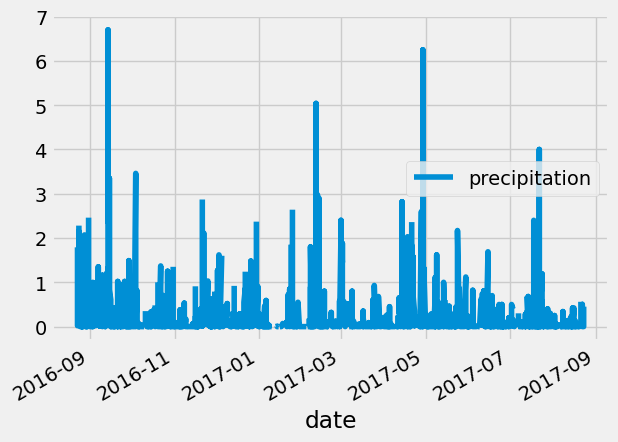

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
sel = [func.max(func.strftime("%Y-%m-%d",Measurement.date))]

recent_date = session.query(*sel).scalar()
recent_date
query_date = dt.datetime.strptime(str(recent_date), "%Y-%m-%d").date()
query_date
query_date = query_date - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
result_Station = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
result_df = pd.DataFrame(result_Station, columns=["date","precipitation"])

result_df['date'] =  pd.to_datetime(result_df['date'], format='%Y-%m-%d')

# Sort the dataframe by date
result_df = result_df.sort_values("date", ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
result_df.plot(x="date",y="precipitation") 

In [21]:
# Use Pandas to calculate the summary statistics for the precipitation data
ss=pd.DataFrame(result_df["precipitation"]).describe()
ss

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [22]:
# Design a query to calculate the total number of stations in the dataset
sel = [func.count(Station.station)]

stations_query = session.query(*sel).scalar()
stations_query

print(f"The number of stations is ",stations_query)

The number of stations is  9


In [23]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.id)]

stations_first_query = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()
stations_first_query 
stations_active_query = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
stations_active_query 



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
most_active = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs), func.count(Measurement.tobs)).filter(Measurement.station=="USC00519281").filter(Measurement.date >="2016-08-23").all()
most_active

[(59.0, 83.0, 73.10795454545455, 352)]

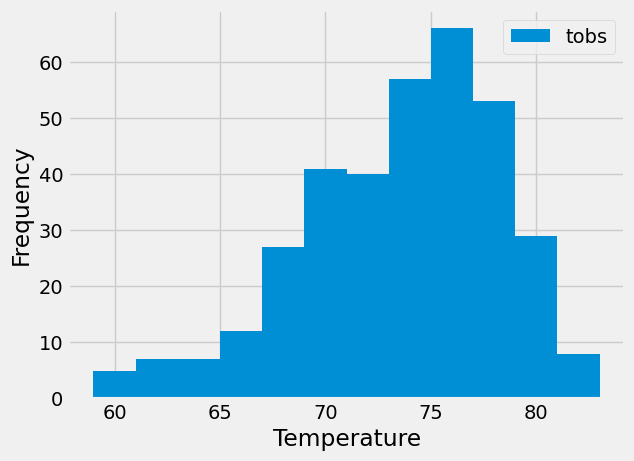

In [37]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_most_active = session.query(Measurement.tobs).filter(Measurement.station=="USC00519281").filter(Measurement.date >="2016-08-23").all()
temp_active_df = pd.DataFrame(temp_most_active, columns=["tobs"])
temp_active_df.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.show()

# Close Session

In [26]:
# Close Session
session.close()